In [1]:
%matplotlib inline

In [2]:
import sys
import os
import pandas as pd
import xarray as xr
from scipy.io import loadmat
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh

from tonic.io import read_configobj

from da_utils import (load_nc_and_concat_var_years, da_2D_to_3D_from_SMART,
                      setup_output_dirs, rmse)

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# ============================================================ #
# Process command line arguments
# Read config file
# ============================================================ #
cfg = read_configobj(
    '/civil/hydro/ymao/data_assim/control/run_SMART/34.6875_-94.9375/EnKS.prec_std_1.with_SM_error.tune_to_truth.Q9.cfg')

In [5]:
# ============================================================ #
# Parameters
# ============================================================ #
start_date = pd.datetime.strptime(cfg['SMART_RUN']['start_date'], "%Y-%m-%d")
end_date = pd.datetime.strptime(cfg['SMART_RUN']['end_date'], "%Y-%m-%d")
start_year = start_date.year
end_year = end_date.year
window_size = cfg['SMART_RUN']['window_size']

In [6]:
# ============================================================ #
# Load original and true prec data
# ============================================================ #
print('Loading data...')

# --- Load original prec (to be corrected) --- #
mat_smart_input = os.path.join(cfg['CONTROL']['root_dir'],
                               cfg['OUTPUT']['output_basedir'],
                               'prep_SMART', 'SMART_input.mat')
dict_smart_input = loadmat(mat_smart_input)

# --- Load original prec --- #
prec_orig = dict_smart_input['prec_orig']  # [cell, day]

# --- Load true prec --- #
prec_true = dict_smart_input['prec_true']  # [cell, day]

# Load in domain file
ds_domain = xr.open_dataset(os.path.join(cfg['CONTROL']['root_dir'],
                                         cfg['DOMAIN']['domain_file']))
da_mask = ds_domain['mask']

Loading data...


In [7]:
# --- Load SMART-corrected prec ensemble --- #
mat_prec_corr_ens = os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir'],
                                 'run_SMART', 'SMART_corrected_rainfall_ens.mat')
prec_corr_ens = loadmat(mat_prec_corr_ens)['RAIN_SMART_SMOS_ENS']  # [window, ens, grid_cell]

In [8]:
# --- Load SMART-corrected prec ensemble mean --- #
mat_prec_corr = os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir'],
                                 'run_SMART', 'SMART_corrected_rainfall.mat')
prec_corr = loadmat(mat_prec_corr)['RAIN_SMART_SMOS']  # [window, grid_cell]

In [9]:
# --- Load lambda --- #
mat_lambda = os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir'],
                                 'run_SMART', 'lambda.mat')
lambda_fraction = loadmat(mat_lambda)['lambda']

In [10]:
# --- Load innovation --- #
mat_innovation = os.path.join(
    cfg['CONTROL']['root_dir'],
    cfg['OUTPUT']['output_basedir'],
    'run_SMART', 'innovation.mat')
innovation = loadmat(mat_innovation)['innovation']

In [11]:
# ============================================================ #
# Aggregate original & true precip. to window size
# ============================================================ #
# Only keep complete windows
n_windows = len(prec_corr_ens)
prec_orig = prec_orig[:, :(n_windows*window_size)]
prec_true = prec_true[:, :(n_windows*window_size)]

In [12]:
# Aggregate windows
ncell = len(prec_orig)
prec_orig_window = prec_orig.reshape(
    [ncell, n_windows, window_size]).sum(axis=2)  # [cell, window]
prec_true_window = prec_true.reshape(
    [ncell, n_windows, window_size]).sum(axis=2)  # [cell, window]

In [ ]:
# ============================================================ #
# Just some visual checking
# ============================================================ #

In [22]:
ds_prec_corrected_rescaled = xr.open_dataset(os.path.join(cfg['CONTROL']['root_dir'],
                    cfg['OUTPUT']['output_basedir'],
                    'post_SMART', 'prec_corrected.1980.nc'))
da_prec_corrected_rescaled = ds_prec_corrected_rescaled['prec_corrected']

In [30]:
da_prec_corrected_rescaled_daily = da_prec_corrected_rescaled.groupby('time.date').sum()

In [47]:
prec_corrected_rescaled = da_prec_corrected_rescaled_daily.values[:(n_windows*window_size)]
prec_corrected_rescaled = prec_corrected_rescaled.reshape(
    [n_windows, window_size]).sum(axis=1)

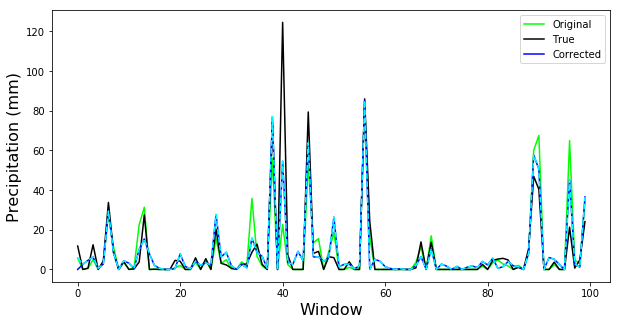

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(prec_orig_window[0, :100], color='lime', label='Original')
plt.plot(prec_true_window[0, :100], color='black', label='True')
plt.plot(prec_corr[:100, 0], color='blue', label='Corrected')
plt.plot(prec_corrected_rescaled[:100], color='cyan', ls='--')
plt.xlabel('Window', fontsize=16)
plt.ylabel('Precipitation (mm)', fontsize=16)
plt.legend()

In [181]:
# ============================================================ #
# Calculate metrics (all based on window-aggregated precip.) (use post-processed corrected rainfall)
# ============================================================ #

In [182]:
# --- Innovation --- #
innovation[innovation==-999] = np.nan
print(np.nanmean(innovation), np.nanstd(innovation))

0.0458304173263 1.64446634817


In [183]:
# --- Lambda fraction --- #
print(lambda_fraction)

[[1]]


In [184]:
# --- Ensemble-mean RMSE --- #
# Calculate RMSE
rmse_orig = rmse(prec_orig_window.transpose(), prec_true_window.transpose())
rmse_corr = rmse(prec_corr, prec_true_window.transpose())

In [185]:
print(rmse_orig, rmse_corr)

[ 13.66497561] [ 12.21570551]


In [186]:
# --- Ensemble-mean bias --- #
bias_orig = prec_orig_window.mean(axis=1) / prec_true_window.mean(axis=1) - 1
bias_corr = prec_corr.mean(axis=0) / prec_true_window.mean(axis=1) - 1

In [188]:
print(bias_orig, bias_corr)

[-0.02673477] [ 0.01320833]


In [189]:
# --- Mean correlation --- #
corrcoef_orig = [np.corrcoef(prec_orig_window[i, :], prec_true_window[i, :])[0, 1] for i in range(ncell)]
corrcoef_corr = [np.corrcoef(prec_corr[:, i], prec_true_window[i, :])[0, 1] for i in range(ncell)]
corrcoef_orig = np.asarray(corrcoef_orig)
corrcoef_corr = np.asarray(corrcoef_corr)

In [190]:
print(corrcoef_orig, corrcoef_corr)

[ 0.76868437] [ 0.82374071]


# Test

In [ ]:
from da_utils import da_2D_to_3D_from_SMART, da_3D_to_2D_for_SMART

In [ ]:
active_cells = np.arange(1, 4000).reshape([1, 3999])
dict_array_2D = {'cell_index': active_cells}  # [1, cell]

In [ ]:
dict_da_3D = da_2D_to_3D_from_SMART(dict_array_2D, da_mask,
                       out_time_varname='time',
                       out_time_coord=[0])

In [ ]:
dict_da_3D['cell_index'].loc[:, 34.6875, -94.9375]

In [100]:
ds_sm = xr.open_dataset(
    ('/civil/hydro/ymao/data_assim/output/synthetic_data/34.6875_-94.9375/'
     'random1.small_SM_error.R_1.Maurer_param/synthetic_meas/synthetic_meas.19800101_19891231.nc'))

In [105]:
da_sm = ds_sm['simulated_surface_sm']
da_sm.time

<xarray.DataArray 'time' (time: 3652)>
array(['1980-01-02T00:00:00.000000000', '1980-01-03T00:00:00.000000000',
       '1980-01-04T00:00:00.000000000', ...,
       '1989-12-29T00:00:00.000000000', '1989-12-30T00:00:00.000000000',
       '1989-12-31T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    nlayer   int64 0
  * time     (time) datetime64[ns] 1980-01-02 1980-01-03 1980-01-04 ...

In [106]:
da_daily = da_sm.groupby('time.date').mean(dim='time')